# FORCE LLM Hackathon November 2023 Starter Pack 

## Introduction

## Setup

In [1]:
from datasets import load_dataset, ClassLabel, Value, Features

## Exploratory Data Analysis

### Imports

In [8]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Loading the scrubbed dataset

In [20]:
corpora = {
    "NL_NOG_PR": "Netherlands - Netherlands Oil & Gas Portal reports.csv",
    "NO_NPD_DI": "Norway - Diskos reports.csv",
    "NO_NPD_RR": "Norway - Norwegian Petroleum Directorate relinquishment reports.csv",
    "UK_NTA_NDR": "UK - North Sea Transition Authority NDR reports.csv",
    "UK_NTA_RR": "UK - North Sea Transition Authority relinquishment reports.csv"
}

class_names = list(corpora.keys())
features = Features({'doc_id': Value('string'), 'meta': Value('string'), 'raw_content': Value('string')})

force_llm_dataset_scrubbed = load_dataset("json", data_files="../data/force_llm_corpus_scrubbed.jsonl", features=features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/Users/lmoss/Documents/GitHub/force_npd_llm_hackathon/venv/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [21]:
force_llm_dataset_scrubbed

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'meta', 'raw_content'],
        num_rows: 2941971
    })
})

### Analysing the length of the documents

  0%|          | 0/2941971 [00:00<?, ?it/s]

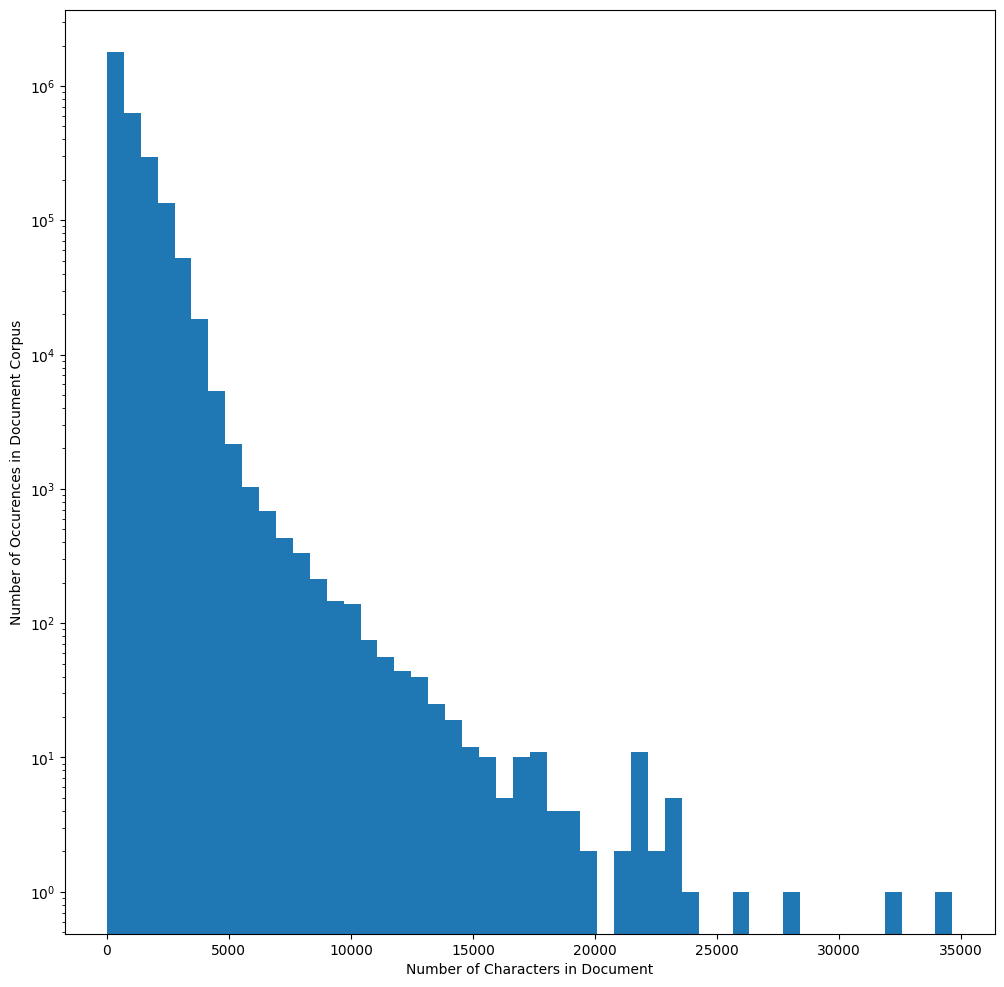

In [43]:
document_lengths = [len(row['raw_content']) for row in tqdm(force_llm_dataset_scrubbed['train'])]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.hist(document_lengths, bins=50)
ax.set_yscale("log")
ax.set_ylabel("Number of Occurences in Document Corpus")
ax.set_xlabel("Number of Characters in Document")
plt.show()

### Estimating the proportions of languages

  0%|          | 0/2941971 [00:00<?, ?it/s]

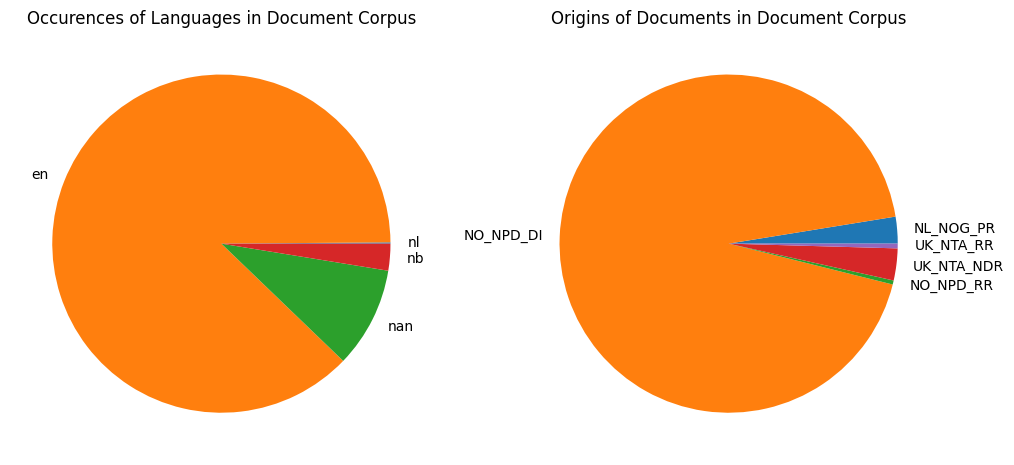

In [42]:
import json
from collections import Counter

corpus_counter = Counter()
language_counter = Counter()
for row in tqdm(force_llm_dataset_scrubbed['train']):
    meta_dict = json.loads(row['meta'])
    language_counter.update([meta_dict['possible_lanaguage']])
    corpus_counter.update([meta_dict['corpus']])

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title("Occurences of Languages in Document Corpus", fontsize=12)
ax[0].pie([val for _, val in language_counter.items()], labels=language_counter.keys())

ax[1].set_title("Origins of Documents in Document Corpus", fontsize=12)
ax[1].pie([val for _, val in corpus_counter.items()], labels=corpus_counter.keys())
plt.show()

### Estimating Word Counts

#### Defining a function to preprocess the documents and split them into words

In [159]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from text_normalizer import normalize

# Make sure to download the necessary NLTK data
import nltk

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    """
    This function takes a string and removes non-sensical punctuation while trying to keep
    the punctuation that is part of technical terms or descriptions of equipment.

    Thanks ChatGPT - following prompt used:
    Can you give me some regex that will when preprocessing the following document remove all the punctuation that is non sensical but keep the one that is important for words or descriptions of equipment. We can also remove all occurrences of 

    Here the original text: INAM 350.41.04 12.0 Top Casingaok oorspr./beh. Tafel: —• 15 . 67 N.A.P. ..1 Onderstand: 8,25 fa. Top 20 'Bod. fl ens 'Casingsok. ../x in. N.A.P EINORAPPORT Terrein : Co evorden Prit No : 21 Loc. : YOV Samenvatting werkzaamheden Type boring: Appraisal Intallatie; 14  ..Montage. v.amaf: ,19 ; uur Coirdinaten: X= + Y. + Hoogte Kelderrand • +/x in NAP Toestand Werkdiepte: 3294 . 75 in. Top cement in link Casing( bs/ft, Gesleufd(...XGeperf.( mm; soh /m ) • ra. m. Aanv.Werkz heden: ,19802200 uur Einde Werkz.heden: 18/ 11,1980; „ 00 uur Einde Demontage: / 19 ; mr Aantal Boordagen/keparatiedagen: .Totaal..dapn. : 107 20 uur .. 80 Top Hanger/Packer/Gel , -trechter • 318 , 55 igalotaircxis (c 11 212,14 cateder ittecttc tax( it .flodem liner : 35.02-4.5.. geoementeerd , 3207,25 • Verbui zingen .2.8 'Stoye pipe Ingeheid tot ; 36 AmmatmxkW4x Driven in, ... MS/ft . : - rn. Top..c.ement. surf 13 3/8 lbs/ft, - in. lbs/ ft, ; - rn. Top cement: 1250 .S‘./C.B.L.) 9 5/8 it 535 lbsift,.. .L - 25.1.0.. ED in. 1.0.8 1.1.0M... —2789..2.. in. Top cement; m.(T.S.14(idx.i 53.5 Pile 7 casing 29 .._lbsift. I, .:.0 - .. ...lbsift, M. lbs/ft„ : - rn. 1 bs/ ft. In. . bb'id 01.1fadc..a,t,-) .long...length...f.ree Einddiepte: 3502.3.5... afgehangen aan Rats SRT - Head Tubingat 3283 Put afgewerkt met SRT Top cement in 4i/3i  iner st 3294, 75 B jgrncterheden:.. Ga gevuld met •Ca012. brine s.g. 4i kill string ingelaten 200 cement inside liner tot -1 m. above top liner hanger ± m. opgestaan met Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,.get es.t .30.0 bar .. UREN SPECIFICAT1E Verh .km. boren kernen montage * demontage bei tel a/bodem round tr diversen k.a.a./bodem roundtrip Uren Totaal in. (eff. m.) ><X testen Schlumberger verbui z./cementeren plyggen zet ten productief maken vangwerk reparatie op onthoud tEinddr.uk • Jubing: ;. .Sarnenstelling • shoe + 352 jts + 11e117Nipple, total .Afgehangen..aan• SET 5000 head RAMS .Gravel pack: ..nun. Kg/czn2 liturbehandelincr  inoomodr.ukiSqueezerlruk• Katcrn2. Type producent: .P.roducti.ev.e..flormatie. ZEZ 2C + ZEZ 2C of Tot. (excl mint. demont. ) 100 ILL.; Fauveau frei • • Excl. Vdoracatags C, liasco-f

    Here the split tokenized example as you can see it currently keeps a bunch of punctuation which it shouldn't: ['INAM', '..', '.', 'Top', 'Casingaok', 'oorspr./beh', '.', 'Tafel', ':', '—•', '.', 'N.A.P', '.', '..', 'Onderstand', ':', ',', 'fa', '.', 'Top', "'Bod", '.', 'fl', 'ens', "'Casingsok", '.', '/x', 'in', '.', 'N.A.P', 'EINORAPPORT', 'Terrein', ':', 'Co', 'evorden', 'Prit', 'No', ':', 'Loc', '.', ':', 'YOV', 'Samenvatting', 'werkzaamheden', 'Type', 'boring', ':', 'Appraisal', 'Intallatie', ';', 'Montage', '.', 'v.amaf', ':', ',', ';', 'uur', 'Coirdinaten', ':', 'X=', '+', 'Y', '.', '+', 'Hoogte', 'Kelderrand', '•', '+/x', 'in', 'NAP', 'Toestand', 'Werkdiepte', ':', '.', 'in', '.', 'Top', 'cement', 'in', 'link', 'Casing', '(', 'bs/ft', ',', 'Gesleufd', '(', 'XGeperf', '.', '(', 'mm', ';', 'soh', '/m', ')', '•', 'ra', '.', 'm.', 'Aanv.Werkz', 'heden', ':', ',', 'uur', 'Einde', 'Werkz.heden', ':', '/', ',', ';', '„', 'uur', 'Einde', 'Demontage', ':', '/', ';', 'mr', 'Aantal', 'Boordagen/keparatiedagen', ':', '.Totaaldapn', '.', ':', 'uur', 'Top', 'Hanger/Packer/Gel', ',', '-trechter', '•', ',', 'igalotaircxis', '(', 'c', ',', 'cateder', 'ittecttc', 'tax', '(', 'it', '.flodem', 'liner', ':', '.-4', '...', 'geoementeerd', ',', ',', '•', 'Verbui', 'zingen', '..', "'Stoye", 'pipe', 'Ingeheid', 'tot', ';', 'AmmatmxkW4x', 'Driven', 'in', ',', 'MS/ft', '.', ':', '-', 'rn', '.', 'Topc.ement', '.', 'surf', '/8', 'lbs/ft', ',', '-', 'in', '.', 'lbs/', 'ft', ',', ';', '-', 'rn', '.', 'Top', 'cement', ':', '.S', '‘', './C.B.L', '.', ')', '/8', 'it', 'lbsift', ',', '.L', '-', '....', 'ED', 'in', '.', '..', '..', '0M', '—', '....', 'in', '.', 'Top', 'cement', ';', 'm.', '(', 'T.S', '.', '(', 'idx.i', '.', 'Pile', 'casing', '_lbsift', '.', 'I', ',', '.', ':', '.', '-', 'lbsift', ',', 'M.', 'lbs/ft', '„', ':', '-', 'rn', '.', 'bs/', 'ft', '.', 'In', '.', '.', "bb'id", '.1fadca', ',', 't', ',', '-', ')', '.longlengthf.ree', 'Einddiepte', ':', '...', 'afgehangen', 'aan', 'Rats', 'SRT', '-', 'Head', 'Tubingat', 'Put', 'afgewerkt', 'met', 'SRT', 'Top', 'cement', 'in', '4i/3i', 'iner', 'st', ',', 'B', 'jgrncterheden', ':', 'Ga', 'gevuld', 'met', '•Ca012', '.', 'brine', 's.g.', '4i', 'kill', 'string', 'ingelaten', 'cement', 'inside', 'liner', 'tot', '-', 'm.', 'above', 'top', 'liner', 'hanger', '±', 'm.', 'opgestaan', 'met', 'Dynadrill', '+', 'Nowsco', 'Coiled', 'Oaaterking.en•.Head.', ',', '.get', 'es.t', '..', 'bar', 'UREN', 'SPECIFICAT1E', 'Verh', '.km', '.', 'boren', 'kernen', 'montage', '*', 'demontage', 'bei', 'tel', 'a/bodem', 'round', 'tr', 'diversen', 'k.a.a./bodem', 'roundtrip', 'Uren', 'Totaal', 'in', '.', '(', 'eff', '.', 'm.', ')', '>', '<', 'X', 'testen', 'Schlumberger', 'verbui', 'z./cementeren', 'plyggen', 'zet', 'ten', 'productief', 'maken', 'vangwerk', 'reparatie', 'op', 'onthoud', 'tEinddr.uk', '•', 'Jubing', ':', ';', '.', '.Sarnenstelling', '•', 'shoe', '+', 'jts', '+', '11e117Nipple', ',', 'total', '.Afgehangenaan•', 'SET', 'head', 'RAMS', '.Gravel', 'pack', ':', 'nun', '.', 'Kg/czn2', 'liturbehandelincr', 'inoomodr.ukiSqueezerlruk•', 'Katcrn2', '.', 'Type', 'producent', ':', '.P.roducti.ev.eflormatie', '.', 'ZEZ', '2C', '+', 'ZEZ', '2C', 'of', 'Tot', '.', '(', 'excl', 'mint', '.', 'demont', '.', ')', 'ILL.', ';', 'Fauveau', 'frei', '•', '•', 'Excl', '.', 'Vdoracatags', 'C', ',', 'liasco-f']
    """
    
    # Regex to remove non-sensical punctuation
    regex_pattern = r"(?<!\d)[.,;:!?](?!\d)|(?<=\s)[-/](?=\s)|(?<=[a-zA-Z])[/](?=\s)"
    
    # Replace the matched characters with an empty string
    cleaned_text = re.sub(regex_pattern, '', text)
    
    return cleaned_text

def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r'(?<!\d)[.-]{2,}(?!\d)', '', text)
    
    text = clean_text(text)
    
    # Tokenize text
    words = word_tokenize(text)

    return words

for row in force_llm_dataset_scrubbed['train']:
    print(row['raw_content'])
    print(preprocess(row['raw_content']))
    break

INAM 350.41.04 12.0 Top Casingaok oorspr./beh. Tafel: —• 15 . 67 N.A.P. ..1 Onderstand: 8,25 fa. Top 20 'Bod. fl ens 'Casingsok. ../x in. N.A.P EINORAPPORT Terrein : Co evorden Prit No : 21 Loc. : YOV Samenvatting werkzaamheden Type boring: Appraisal Intallatie; 14  ..Montage. v.amaf: ,19 ; uur Coirdinaten: X= + Y. + Hoogte Kelderrand • +/x in NAP Toestand Werkdiepte: 3294 . 75 in. Top cement in link Casing( bs/ft, Gesleufd(...XGeperf.( mm; soh /m ) • ra. m. Aanv.Werkz heden: ,19802200 uur Einde Werkz.heden: 18/ 11,1980; „ 00 uur Einde Demontage: / 19 ; mr Aantal Boordagen/keparatiedagen: .Totaal..dapn. : 107 20 uur .. 80 Top Hanger/Packer/Gel , -trechter • 318 , 55 igalotaircxis (c 11 212,14 cateder ittecttc tax( it .flodem liner : 35.02-4.5.. geoementeerd , 3207,25 • Verbui zingen .2.8 'Stoye pipe Ingeheid tot ; 36 AmmatmxkW4x Driven in, ... MS/ft . : - rn. Top..c.ement. surf 13 3/8 lbs/ft, - in. lbs/ ft, ; - rn. Top cement: 1250 .S‘./C.B.L.) 9 5/8 it 535 lbsift,.. .L - 25.1.0.. ED i

[nltk_data] Downloading package stopwords to /Users/lmoss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lmoss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Creating some helper functions to count the number of words

In [160]:
import json
from collections import Counter
from tqdm.auto import tqdm

# Create a counter to count word tokens
word_freq = Counter()
for row in tqdm(force_llm_dataset_scrubbed['train']):
    words = preprocess(row['raw_content'])
    word_freq.update(words)

  0%|          | 0/2941971 [00:00<?, ?it/s]

Let's look at the top 100 most frequent words. 

In [161]:
dict(word_freq.most_common(30))

{'the': 11422861,
 ')': 7418152,
 '(': 7017208,
 'to': 6501109,
 'and': 5913138,
 'of': 5629201,
 'in': 4202731,
 '•': 2488342,
 '*': 2454780,
 'at': 2236734,
 'with': 1991908,
 'well': 1917675,
 'is': 1886968,
 'was': 1873706,
 'from': 1824410,
 'no': 1727391,
 "'": 1693744,
 'on': 1621494,
 'for': 1493204,
 'hole': 1416917,
 '.': 1383856,
 ':': 1376252,
 'depth': 1367497,
 '%': 1346895,
 'pressure': 1307065,
 ',': 1212177,
 'm': 1128298,
 'this': 1051788,
 'be': 1048617,
 '1': 1015170}

#### Creating the dictionary of words for the dataset

In [166]:
# We will only consider words that have 100 or more occurences. 
common_words = {word for word, freq in word_freq.items() if freq >= 500}
word_dict = {word: idx for idx, (word, _) in enumerate(word_freq.most_common()) if word in common_words}

Let's look at the final word dictionary

In [167]:
print(f"Number of words in dictionary: {len(word_dict)}")
print({word: key for idx, (word, key) in enumerate(word_dict.items()) if idx < 100})

Number of words in dictionary: 34090
{'the': 0, ')': 1, '(': 2, 'to': 3, 'and': 4, 'of': 5, 'in': 6, '•': 7, '*': 8, 'at': 9, 'with': 10, 'well': 11, 'is': 12, 'was': 13, 'from': 14, 'no': 15, "'": 16, 'on': 17, 'for': 18, 'hole': 19, '.': 20, ':': 21, 'depth': 22, '%': 23, 'pressure': 24, ',': 25, 'm': 26, 'this': 27, 'be': 28, '1': 29, 'time': 30, 'as': 31, 'are': 32, 'by': 33, 'data': 34, 'mud': 35, '=': 36, 'out': 37, 'up': 38, 'section': 39, 'drilling': 40, 'gas': 41, 'i': 42, 'date': 43, 'formation': 44, 'md': 45, '10': 46, 'were': 47, 'a': 48, 'run': 49, 'test': 50, 'bit': 51, 'page': 52, 'it': 53, 'casing': 54, 'report': 55, '[': 56, '&': 57, ']': 58, '#': 59, 'oil': 60, '0': 61, 'nmp': 62, 'or': 63, '2': 64, 'bar': 65, 'core': 66, '1/2': 67, 'top': 68, 'total': 69, 'cement': 70, 'that': 71, '12': 72, '4': 73, 'water': 74, 'sample': 75, '+': 76, 'type': 77, '20': 78, 'not': 79, 'an': 80, 'tool': 81, 'interval': 82, 'drill': 83, '—': 84, '11': 85, 'down': 86, 'rig': 87, 'ii': 88

#### Writing and Reading the word dict from disk (faster)

In [168]:
with open('../data/word_freq_scrubbed.json', 'w') as json_file:
    json.dump(word_freq, json_file, indent=4)

with open('../data/word_dict_scrubbed.json', 'w') as json_file:
    json.dump(word_dict, json_file, indent=4)

# Read the file and convert the JSON content to a Python dictionary
with open('../data/word_freq_scrubbed.json', 'r') as json_file:
    word_freq = json.load(json_file)
    word_freq = Counter(word_freq)

with open('../data/word_dict_scrubbed.json', 'r') as json_file:
    word_dict = json.load(json_file)

idx_word_map = {item: key for key, item in word_dict.items()}

## A first approach: Word2Vec - Creating Word Level Embeddings

### Some necessary imports

In [169]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

### Creating a Word2Vec dataset generator

In [188]:
import numpy as np
import torch
from collections import defaultdict
from itertools import chain, islice

def make_cbow_context(tokenized, window_size=2, deterministic=False):
    # Create context windows using islice for elegant slicing
    for idx in range(window_size, len(tokenized) - window_size):
        ws = np.random.randint(1, window_size) if not deterministic else window_size
        historical = islice(tokenized, idx - ws, idx)
        
        ws = np.random.randint(1, window_size) if not deterministic else window_size
        future = islice(tokenized, idx+1, idx+1 + ws)
        yield list(chain(historical, future)), tokenized[idx]

def pad_sequence(seq, pad_value, max_length):
    # Pad sequence to the required length
    return np.pad(seq, (0, max_length - len(seq)), constant_values=pad_value)

def get_batch(dataset, word_dict, batch_size=32, window_size=2, deterministic=False):
    # Using generator expression for batch creation
    batch_x = []
    batch_y = []
    for row in dataset:
        tokenized = [word_dict.get(word) for word in preprocess(row['raw_content']) if word in word_dict]
        for cbow, target in make_cbow_context(tokenized, window_size=window_size, deterministic=deterministic):
            batch_x.append(cbow)
            batch_y.append(target)
            if len(batch_x) == batch_size:
                max_length = window_size * 2
                # Create padded batch and yield
                padded_x = [pad_sequence(x, len(word_dict), max_length) for x in batch_x]
                mask = np.not_equal(padded_x, len(word_dict))
                yield padded_x, batch_y, mask
                batch_x, batch_y = [], []  # Reset the batches

shuffled_dataset = force_llm_dataset_scrubbed['train'].shuffle(seed=42)

# Main loop to process batches
for i, (X, y, mask) in enumerate(get_batch(shuffled_dataset, word_dict, batch_size=4, window_size=2, deterministic=True)):
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    mask = torch.tensor(mask, dtype=torch.long)
    print(X, y, mask)
    break

tensor([[1754, 3017, 4453,  448],
        [3017, 1109,  448, 2537],
        [1109, 4453, 2537, 4435],
        [4453,  448, 4435,  876]]) tensor([1109, 4453,  448, 2537]) tensor([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]])


### Implementing the Continuous Bag of Words model for word-level embeddings

In [189]:
class CBOW(nn.Module):
    def __init__(self, padding_idx, d_embedding: int = 128, n_vocab: int = 10, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=d_embedding, padding_idx=padding_idx)
        self.linear1 = nn.Linear(d_embedding, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, n_vocab)
        self.activation = nn.ReLU()
    def embed(self, x):
        return self.embedding(x)
    
    def forward(self, x, mask):
        embedded = self.embedding(x)  # Get the embeddings for x
        mask = mask.unsqueeze(-1)     # Add a dimension for broadcasting
        masked_embedded = embedded * mask  # Apply the mask
        sum_embeddings = masked_embedded.sum(dim=1)  # Sum only the masked (valid) embeddings
        hidden_1 = self.activation(self.linear1(sum_embeddings))
        log_probs = F.log_softmax(self.linear2(hidden_1), dim=1)
        return log_probs

#### Splitting the dataset into train and validation

### Training a Continuous Bag of Words model on the corpus

In [190]:
from IPython.display import display
import pandas as pd

def set_styling(df):
    # Assuming your DataFrame 'df' is already created
    # Apply some basic styling to the DataFrame
    styled_df = df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'),
                    ('text-align', 'center'),
                    ('background-color', 'lightgrey'),
                    ('color', 'black')]},
         {'selector': 'td',
          'props': [('text-align', 'center'),
                    ('background-color', 'white'),
                    ('color', 'black'),
                    ('font-size', '10pt')]}
        ]
    ).set_properties(**{'margin': '0 auto'})#.hide_index()
    return styled_df
    
def check_embeddings(model, word):
    word_idx = word_dict[word]
    with torch.no_grad():
        word_vec = model.embedding.weight[word_idx]
        cos = F.cosine_similarity(word_vec.unsqueeze(0), model.embedding.weight, dim=1)
        argsort = torch.argsort(cos, descending=True)
        nearest_neighbors = [idx_word_map[idx.item()] for idx in argsort 
                             if idx != word_idx and idx != len(word_dict)][:10]
        return nearest_neighbors

def get_table_of_nearest_neighbors(model, words_to_validate):
    neighbors_dict = {}
    for word in words_to_validate:
        neighbors_dict[word] = check_embeddings(model, word)

    # Convert the dictionary to a pandas DataFrame for nice tabular display
    df = pd.DataFrame(neighbors_dict.items(), columns=['Word', 'Nearest Neighbors'])
    df.set_index('Word', inplace=True)
    return df

In [191]:
import torch
import random
import numpy as np
import os

def set_seed(seed):
    """Set the random seed for reproducibility."""
    # Python random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Configure PyTorch to be deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage


2939029 2942


0it [00:00, ?it/s]

0it [00:00, ?it/s]

[4.602122136640516] [0]


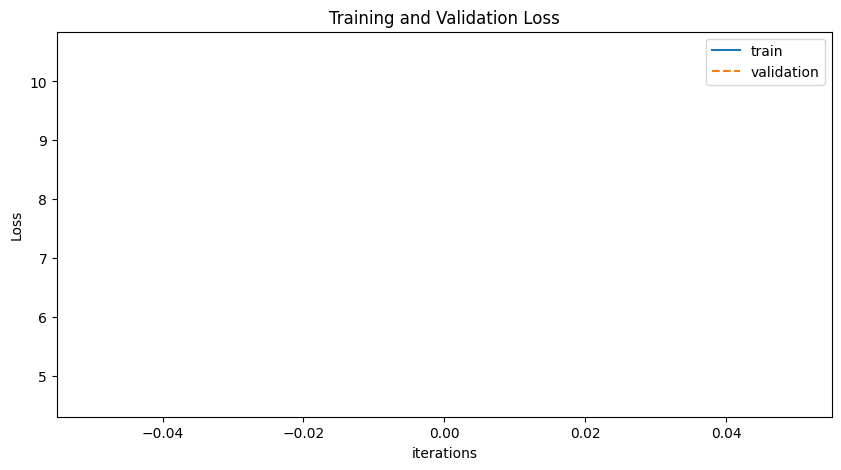

,Nearest Neighbors
Word,
well,"['slb', '4235', '120-', 'ror', 'biosone', 'a17', 'accumulating', 'mexico', 'schwagerina', '2/11-5']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284] [0, 50000]


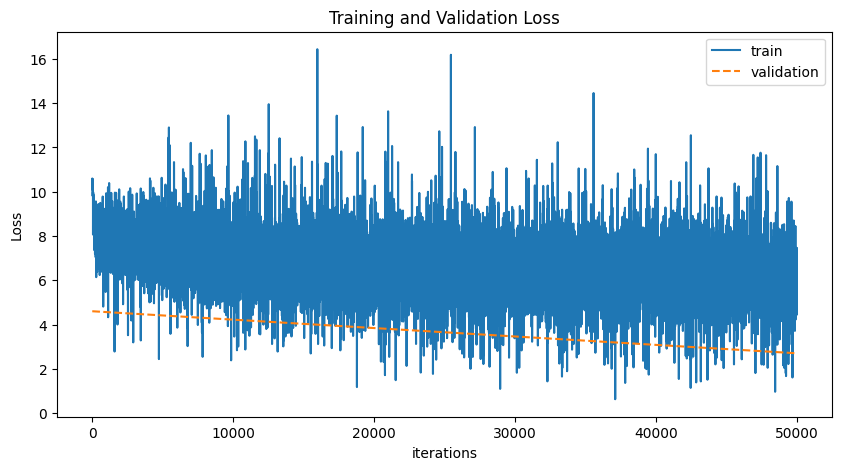

,Nearest Neighbors
Word,
well,"['4235', 'a17', 'biosone', 'a-7', 'johnston', '1.2.1', 'team', '2/11-5', '120-', 'ror']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613] [0, 50000, 100000]


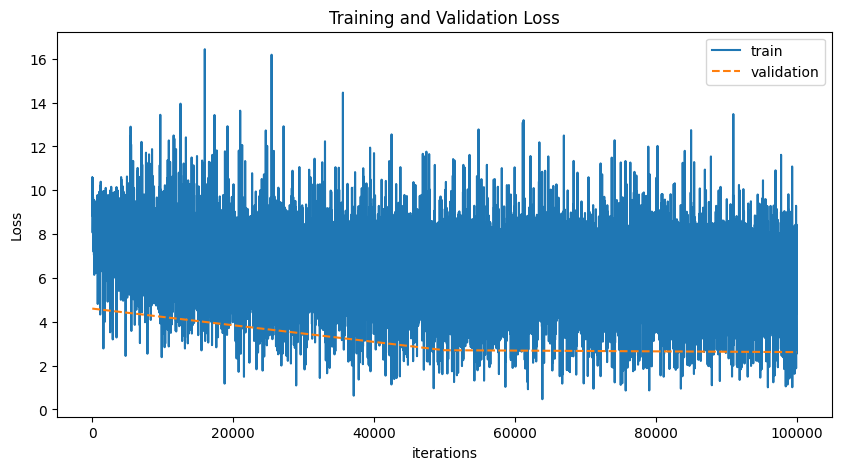

,Nearest Neighbors
Word,
well,"['a-7', 'a17', 'johnston', 'biosone', 'poorly', '1.2.1', '4235', '2/11-5', 'wells', '16:13:00']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616] [0, 50000, 100000, 150000]


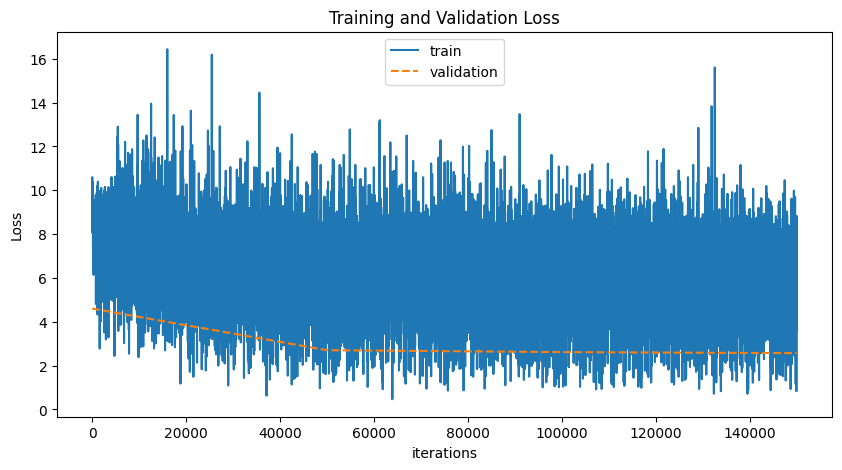

,Nearest Neighbors
Word,
well,"['wells', 'poorly', 'a-7', 'textwell', 'wellpath', 'a17', '2/11-5', 'biosone', 'johnston', '16:13:00']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092] [0, 50000, 100000, 150000, 200000]


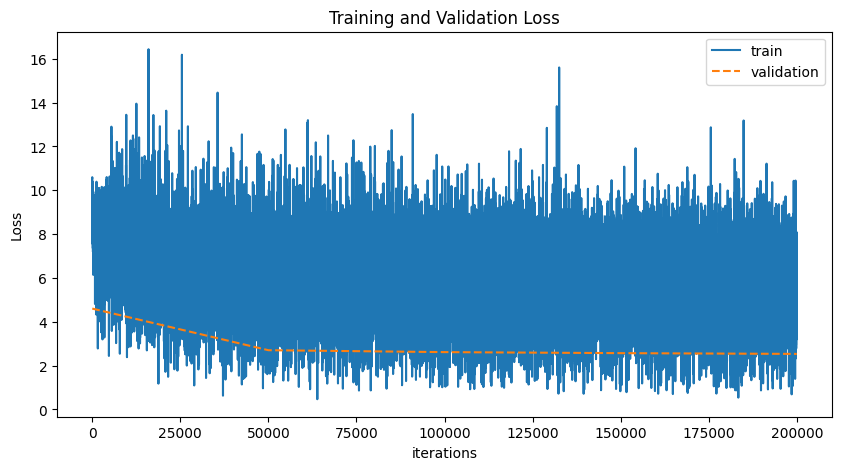

,Nearest Neighbors
Word,
well,"['wells', 'wellpath', 'textwell', 'poorly', '2/11-5', 'a-7', 'nacl/polymer', '31/2-2', 'a17', '34/7-c-2']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052] [0, 50000, 100000, 150000, 200000, 250000]


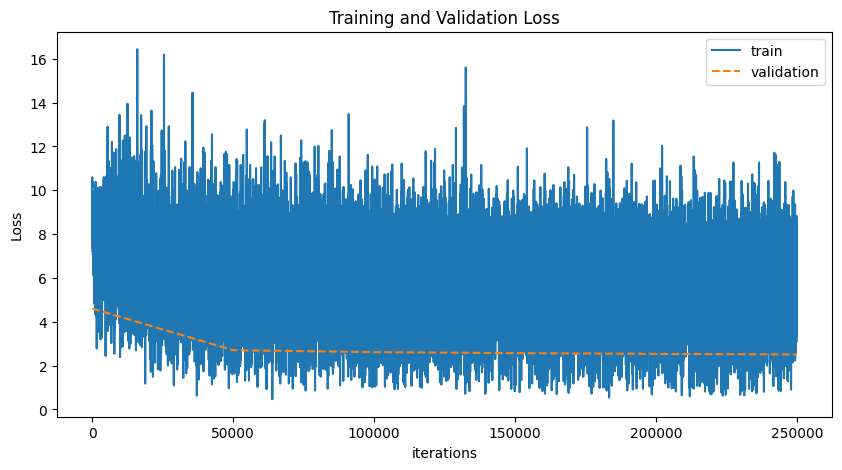

,Nearest Neighbors
Word,
well,"['wells', 'wellpath', 'textwell', '2/11-5', 'nacl/polymer', 'poorly', '34/7-c-2', '31/2-2', 'a17', 'textnell']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023] [0, 50000, 100000, 150000, 200000, 250000, 300000]


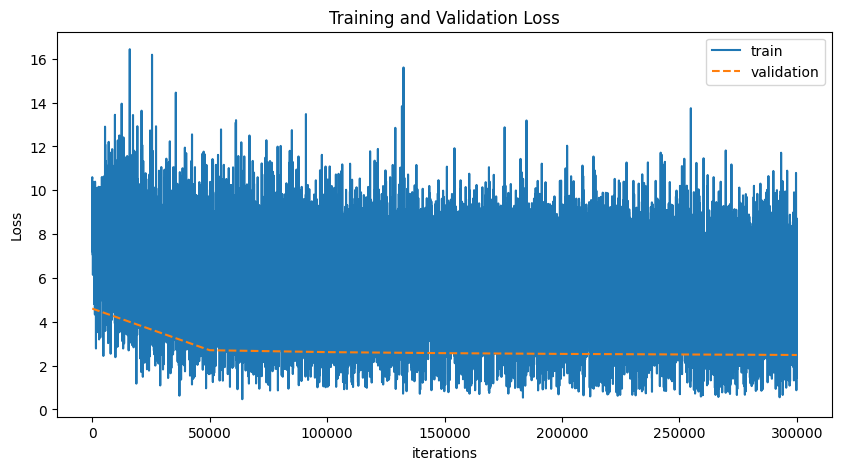

,Nearest Neighbors
Word,
well,"['wells', 'wellpath', '2/11-5', '34/7-c-2', 'poorly', 'nacl/polymer', 'wellbore', '31/2-2', 'a17', 'textnell']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000]


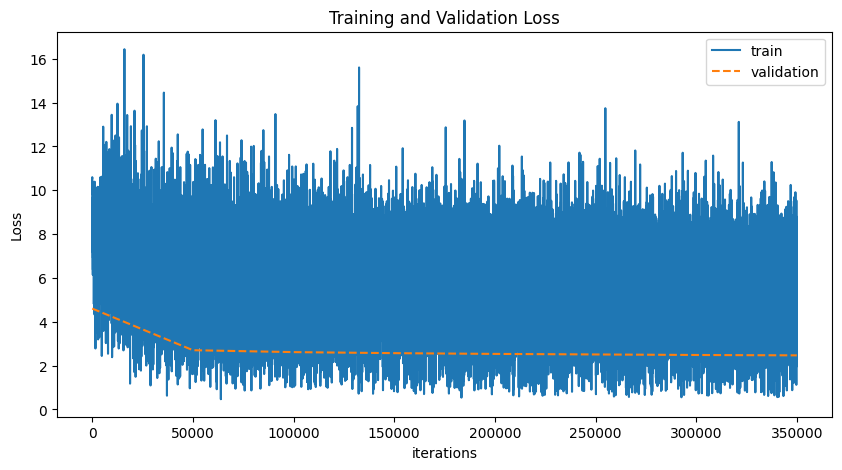

,Nearest Neighbors
Word,
well,"['wells', 'wellpath', '2/11-5', '34/7-c-2', 'wellbore', 'nacl/polymer', 'wel', 'poorly', 'grane', '34/11-3']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]


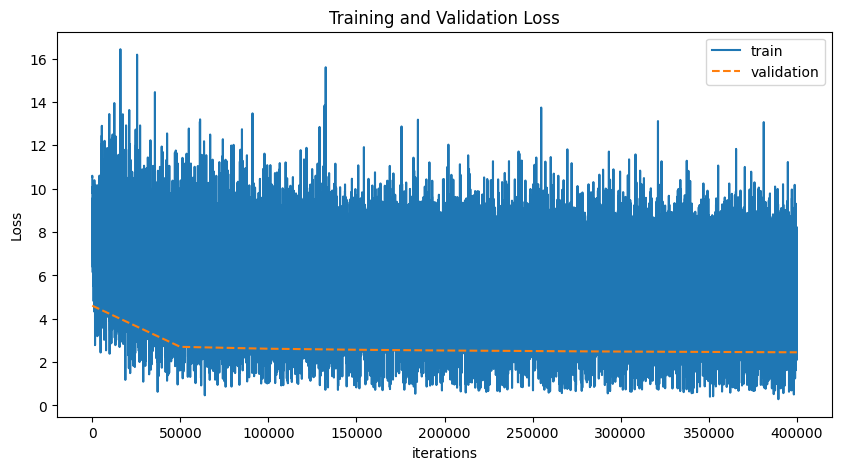

,Nearest Neighbors
Word,
well,"['wells', 'wellpath', 'wellbore', 'nell', '2/11-5', 'wel', 'novalhall', '6407/1-2', '34/7-c-2', 'welltest']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000]


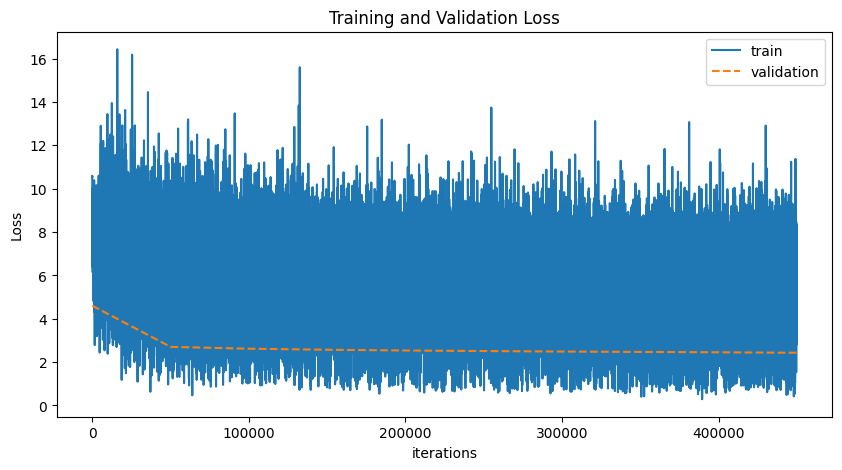

,Nearest Neighbors
Word,
well,"['wells', 'wellbore', 'nell', 'wel', 'wellpath', 'welltest', '2/11-5', 'sidetrack', 'novalhall', 'grane']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]


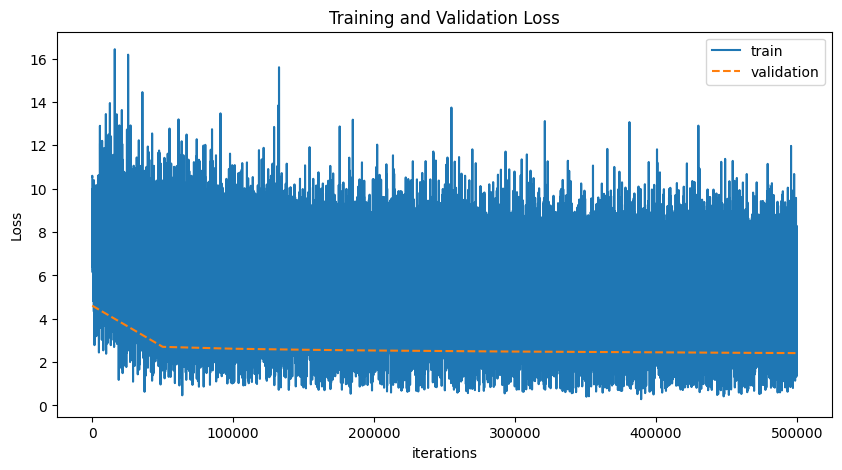

,Nearest Neighbors
Word,
well,"['nell', 'wells', 'wel', 'wellbore', 'welltest', '2/11-5', 'wellpath', 'sidetrack', 'grane', '6507/7-10']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000]


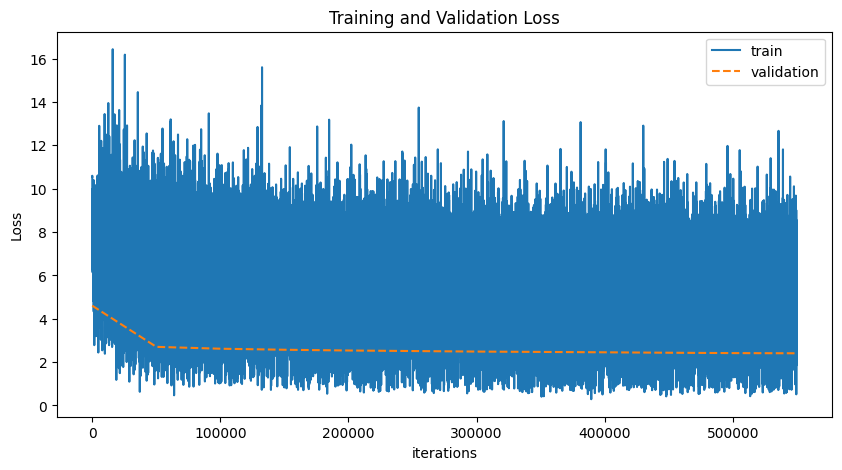

,Nearest Neighbors
Word,
well,"['nell', 'wel', 'well-', '2/11-5', 'wells', 'wellbore', 'welltest', 'wellpath', 'producers', 'sidetrack']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]


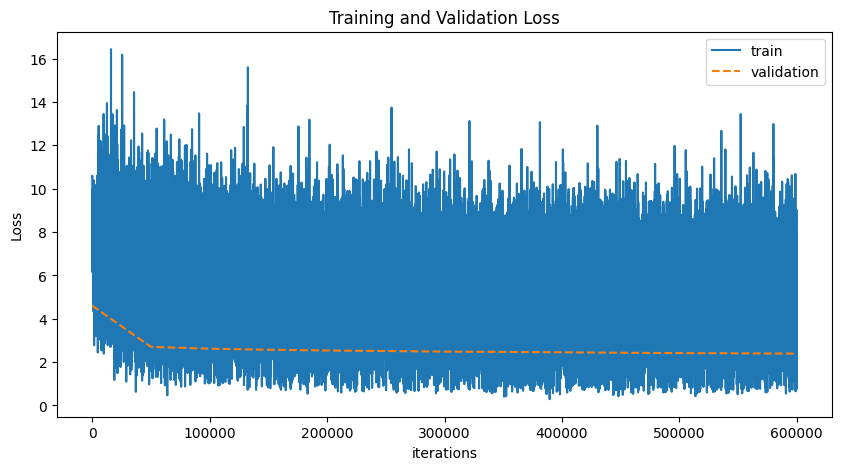

,Nearest Neighbors
Word,
well,"['nell', 'wellbore', 'welltest', 'well-', 'sidetrack', '2/11-5', 'wells', 'wel', 'wellpath', 'novalhall']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000]


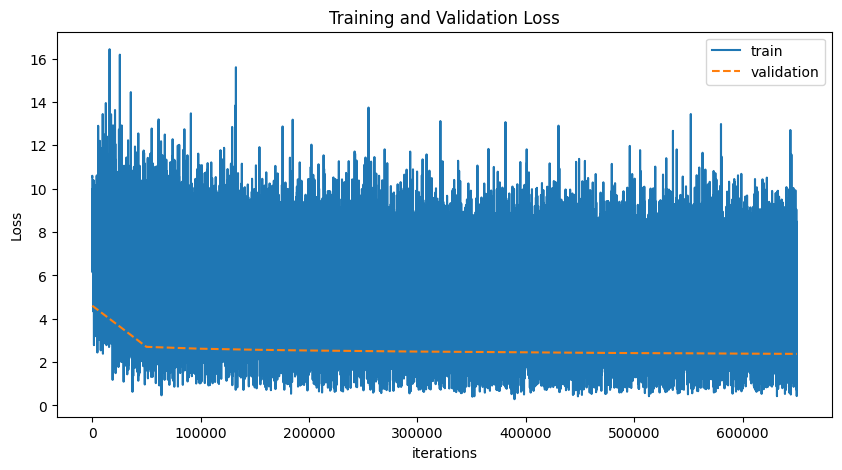

,Nearest Neighbors
Word,
well,"['well-', 'nell', 'welltest', 'wel', 'wells', 'wellbore', 'sidetrack', ""'well"", '2/11-5', 'wellpath']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000]


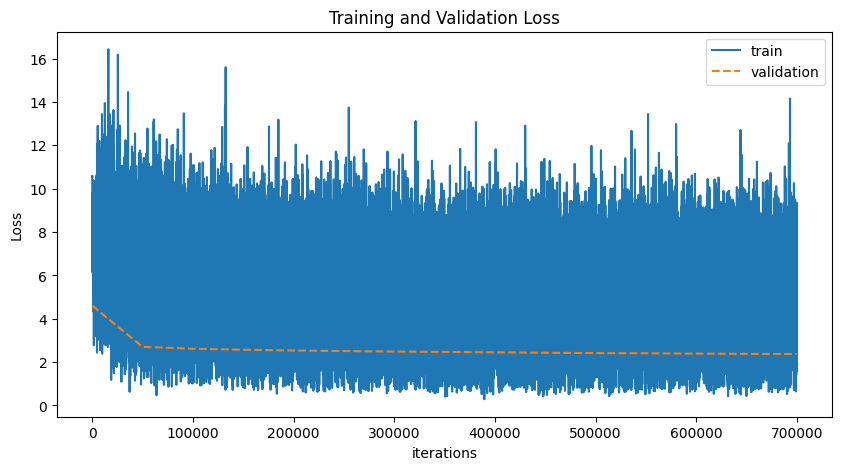

,Nearest Neighbors
Word,
well,"['nell', 'well-', 'welltest', 'wel', 'wells', 'sidetrack', ""'well"", 'hell', '2/11-5', 'iwell']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000]


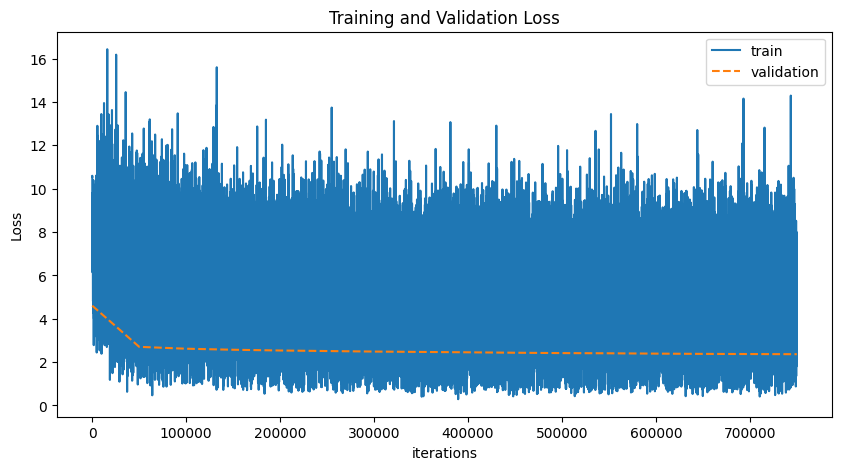

,Nearest Neighbors
Word,
well,"['well-', 'nell', 'wel', 'welltest', 'wells', 'hell', ""'well"", 'wellpaths', 'trud', '31/2-x-11']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338, 2.3571393933529596] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


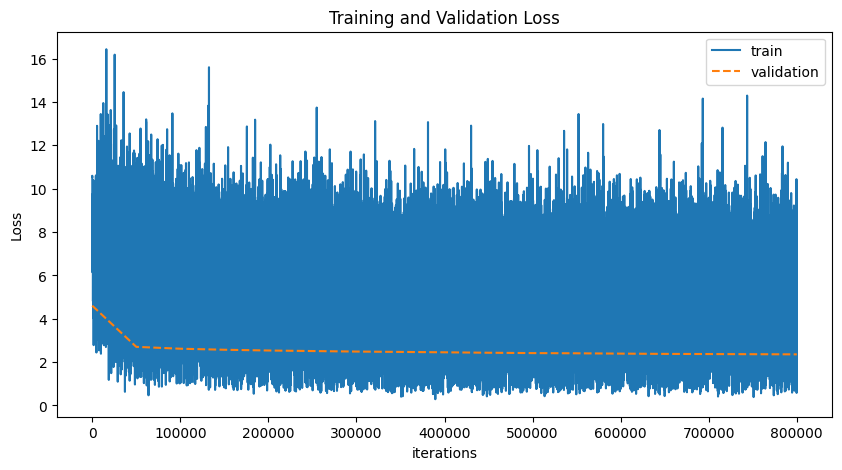

,Nearest Neighbors
Word,
well,"['well-', 'wel', 'nell', ""'well"", 'hell', 'welltest', 'donnatello', 'wells', 'wellpaths', 'trud']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338, 2.3571393933529596, 2.351007187958075] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000]


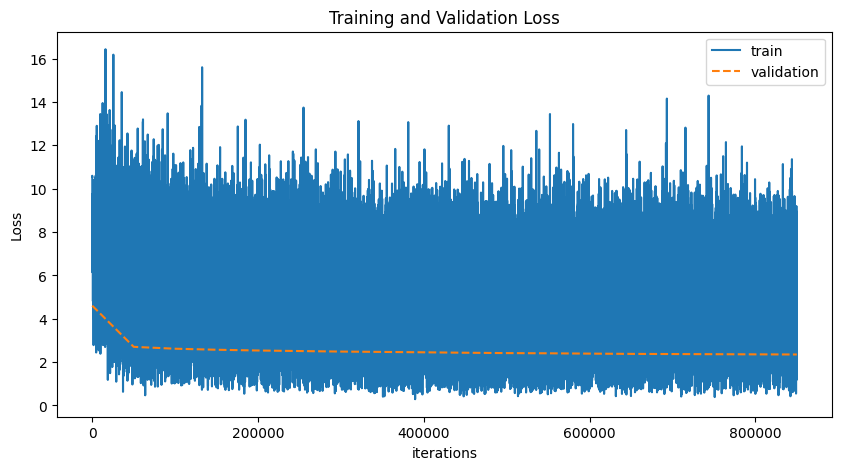

,Nearest Neighbors
Word,
well,"['well-', 'nell', 'hell', ""'well"", 'wel', 'donnatello', 'wells', 'welltest', 'weil', 'trud']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338, 2.3571393933529596, 2.351007187958075, 2.3458168308075233] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000]


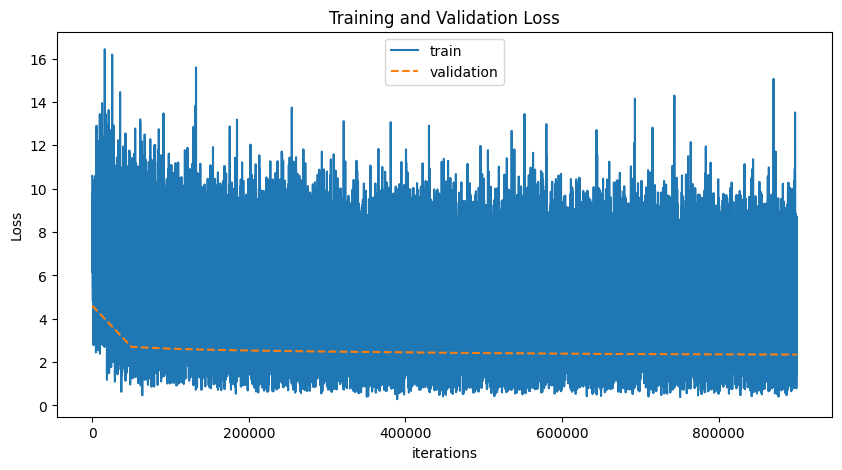

,Nearest Neighbors
Word,
well,"['nell', 'well-', ""'well"", 'hell', 'wel', 'weil', 'wells', 'donnatello', 'wellpaths', '25/11-18t2']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338, 2.3571393933529596, 2.351007187958075, 2.3458168308075233, 2.3421276784283545] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000]


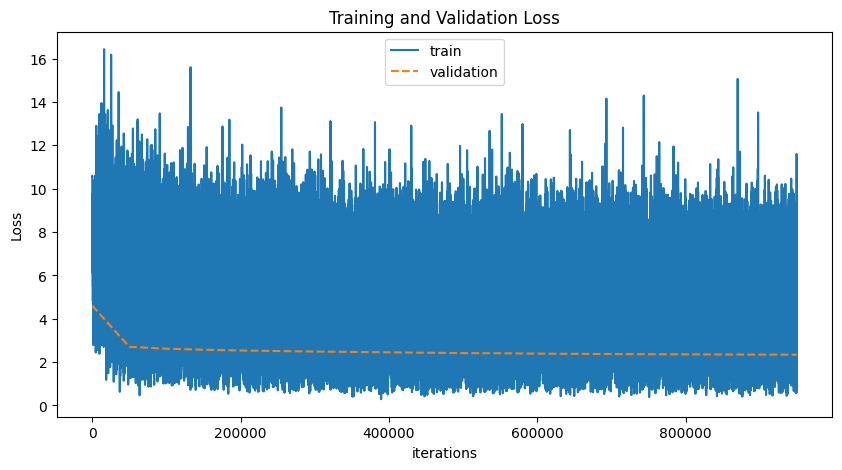

,Nearest Neighbors
Word,
well,"['well-', 'nell', ""'well"", 'hell', 'wells', 'donnatello', 'wel', 'discovery', 'wellpaths', '-well']"


0it [00:00, ?it/s]

[4.602122136640516, 2.7036348279036284, 2.6171248467660613, 2.5697574809973616, 2.5351512603092, 2.510206354183052, 2.4858686640342023, 2.4691788020950853, 2.4519783667283024, 2.4318075738416733, 2.4150764047086524, 2.406191334685527, 2.3908800896862425, 2.3786643392208235, 2.371443489633556, 2.364183785881338, 2.3571393933529596, 2.351007187958075, 2.3458168308075233, 2.3421276784283545, 2.3387502642572535] [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]


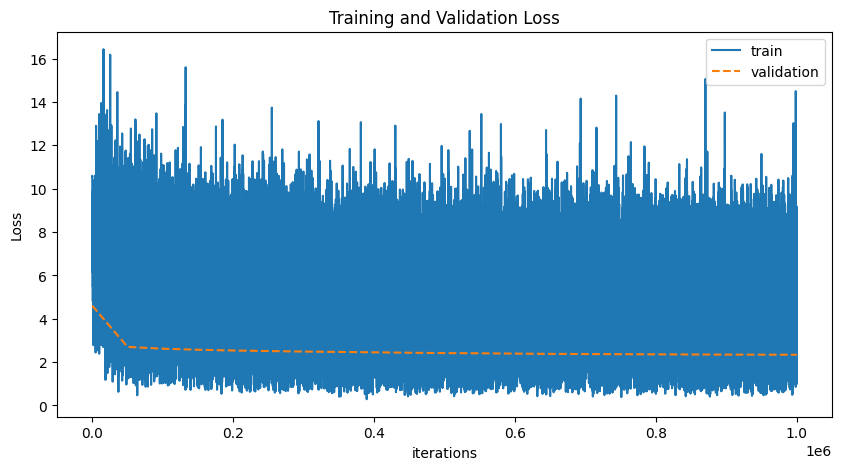

,Nearest Neighbors
Word,
well,"['hell', 'nell', 'well-', 'wel', '-well', ""'well"", 'wells', 'donnatello', 'vvell', 'welt']"


KeyboardInterrupt: 

In [223]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

set_seed(42)
device = "mps"

words_to_validate = ["well"]#, "hole", "porosity", "rock"]
# Define the validate function
def validate(model, valid_dataset, loss_function, word_dict):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No gradients required for validation
        for X_val, y_val, mask_val in tqdm(get_batch(valid_dataset, word_dict, batch_size=256, window_size=2, deterministic=True)):
            X_val = torch.tensor(X_val).to(device)
            y_val = torch.tensor(y_val).to(device)
            mask_val = torch.tensor(mask_val).to(device)
            log_probs_val = model(X_val, mask_val)
            loss = loss_function(log_probs_val, y_val)
            total_loss += loss.item()
    return total_loss / len(valid_dataset)


# Shuffle the dataset
shuffled_dataset = force_llm_dataset_scrubbed.shuffle(seed=42)['train']

# Slice the dataset to create training and validation sets
train_dataset = shuffled_dataset.select(range(int(0.999 * len(shuffled_dataset)))).shuffle(seed=69)
valid_dataset = shuffled_dataset.select(range(int(0.999 * len(shuffled_dataset)), len(shuffled_dataset))).shuffle(seed=420)

print(len(train_dataset), len(valid_dataset))

loss_function = nn.NLLLoss()
model = CBOW(len(word_dict.keys()), 128, len(word_dict.keys())+1, hidden_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

# Initialize lists to store loss values for plotting
train_losses = []
valid_losses = []
valid_iterations = []

# Training loop
prog_bar = tqdm(get_batch(train_dataset, word_dict, batch_size=256, window_size=2, deterministic=True))
for i, (X, y, mask) in enumerate(prog_bar):
    X = torch.tensor(X).to(device)
    y = torch.tensor(y).to(device)
    mask = torch.tensor(mask).to(device)
    
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    log_probs = model(X, mask)
    loss = loss_function(log_probs, y)
    loss.backward()
    optimizer.step()
    prog_bar.set_description_str(f"Loss: {loss.item()}")
    train_losses.append(loss.item())
    
    # Inside your training loop
    if i % 50000 == 0:
        val_loss = validate(model, valid_dataset, loss_function, word_dict)
        valid_losses.append(val_loss)
        valid_iterations.append(i)
        print(valid_losses, valid_iterations)
        # Plotting without pausing the execution
        plt.figure(figsize=(10,5))
        plt.title("Training and Validation Loss")
        plt.plot(range(i+1), train_losses, label="train")  # Update x-axis for training loss
        plt.plot(valid_iterations, valid_losses, label="validation", linestyle='--')  # Plot validation loss against iteration
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.draw()
        plt.pause(0.001)  # Pause briefly to allow the plot to be displayed
        
        # Free up memory after the plot is drawn
        plt.close()

        df = get_table_of_nearest_neighbors(model, words_to_validate)
        df = set_styling(df)
        display(df)

In [225]:
torch.save(model.state_dict(), "../data/cbow_10112023.pth")

In [ ]:
model = CBOW(len(word_dict.keys()), 128, len(word_dict.keys())+1, hidden_dim=128).to(device)
model.load_state_dict(torch.load("../data/cbow_10112023.pth"))

## Using a pre-trained embeddings model: OpenAI embedding-ada-002

In [222]:
from openai import AzureOpenAI
from openai.types import Embedding
from dotenv import load_dotenv
import pytest
import os
import logging

# Load the shared environment variables, not secrets
load_dotenv("../.env.shared")
load_dotenv("../.env.secret")


openai_client = AzureOpenAI(
    api_version=os.environ["OPENAI_API_VERSION"],
    azure_endpoint=os.environ["OPENAI_API_BASE"],
    api_key=os.environ["OPENAI_API_KEY"]
)

embedding = openai_client.embeddings.create(input=["sample text", "other sample text"], 
                                    model=os.environ["ADA002_DEPLOYMENT"])

print(embedding)

NameError: name 'client' is not defined

## From Words to Sentences: Sentence Transformers

## Overcoming the cold-start problem: GPT4 to the Rescue

In [207]:
prompt = lambda a, b: """The following are two pieces of text that may or may not contain related sentences. 
The documents can be in different languages. They all come from the same domain of oil and gas exploration and production. 

You will extract sentences that follow the text closely from both pieces of text.
The sentences should be short and if they are too long can be shortened. 
Make sure there is a mixture of sentences so that the similarity scores are roughly uniform distributed. 

Here the first text: """+a+"""

And here the second text: """+b+""" 

Then you will assign a pair of sentences a SCORE. The SCORE should be based on how semantic similar the two sentences are.

You are to produce a JSON formatted output, with JSON output only in the following form:

[{"1": "<Sentence 1a>", "2": "<Sentence 1b>", "SCORE": <Similarity of 1a and 1b as a number between 0, 1>}, 
 {"1": "<Sentence 2a>", "2": "<Sentence 2b>", "SCORE": <Similarity of 2a and 2b as a number between 0, 1>},
 ...,
 {"1": "<Sentence Na>", "2": "<Sentence Nb>", "SCORE": <Similarity of Na and Nb as a number between 0, 1>}]

Make sure to always include the SCORE
You are to determine yourself how many examples N you can come up with. Just make sure its always JSON formatted.

"""

In [219]:
from openai import AzureOpenAI
from openai.types import Embedding
from dotenv import load_dotenv
import pytest
import os
import logging

# Load the shared environment variables, not secrets
load_dotenv("../.env.shared")
load_dotenv("../.env.secret")


openai_client = AzureOpenAI(
    api_version=os.environ["OPENAI_API_VERSION"],
    azure_endpoint=os.environ["OPENAI_API_BASE"],
    api_key=os.environ["OPENAI_API_KEY"]
)

text_1 = force_llm_dataset_scrubbed["train"][0]["raw_content"]
text_2 = force_llm_dataset_scrubbed["train"][69]["raw_content"]

completion = openai_client.chat.completions.create(model=os.environ["GPT35Turbo16k_DEPLOYMENT"], 
                                            messages=[{"role": "system", 
                                                       "content": "Always provide valid JSON output only!"}, 
                                                       {"role": "user", "content": prompt(text_1, text_2)}])


In [220]:
print(completion)

ChatCompletion(id='chatcmpl-8J85qJ86tsSfqGbAW2VYscOxSQRx0', choices=[Choice(finish_reason='stop', index=0, message=ChatCompletionMessage(content='[\n  {\n    "1": "Top Casingaok oorspr./beh. Tafel: —• 15 . 67 N.A.P",\n    "2": "Top casing is originated from the table 15.67 N.A.P",\n    "SCORE": 0.85\n  },\n  {\n    "1": "Type boring: Appraisal Intallatie; 14  ..Montage. v.amaf: ,19 ; uur",\n    "2": "Boring type: Appraisal Installation; 14 Montage. v.amaf, 19 hours",\n    "SCORE": 0.92\n  },\n  {\n    "1": "Ga gevuld met •Ca012. brine s.g. 4i kill string ingelaten 200 cement inside liner tot -1 m. above top liner hanger ± m. opgestaan met Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,.get es.t .30.0 bar",\n    "2": "Filled with Ca012 brine s.g. 4i kill string lowered 200 cement inside liner to -1 m. above top liner hanger ±m. stood up with Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,. get es.t 30.0 bar",\n    "SCORE": 0.76\n  },\n  {\n    "1": "AYSTDNE: LIGHT TO MEDIUM GREY TO LIGH

In [221]:
json.loads(completion.choices[0].message.content.strip())

[{'1': 'Top Casingaok oorspr./beh. Tafel: —• 15 . 67 N.A.P',
  '2': 'Top casing is originated from the table 15.67 N.A.P',
  'SCORE': 0.85},
 {'1': 'Type boring: Appraisal Intallatie; 14  ..Montage. v.amaf: ,19 ; uur',
  '2': 'Boring type: Appraisal Installation; 14 Montage. v.amaf, 19 hours',
  'SCORE': 0.92},
 {'1': 'Ga gevuld met •Ca012. brine s.g. 4i kill string ingelaten 200 cement inside liner tot -1 m. above top liner hanger ± m. opgestaan met Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,.get es.t .30.0 bar',
  '2': 'Filled with Ca012 brine s.g. 4i kill string lowered 200 cement inside liner to -1 m. above top liner hanger ±m. stood up with Dynadrill + Nowsco Coiled Oaaterking.en•.Head.,. get es.t 30.0 bar',
  'SCORE': 0.76},
 {'1': 'AYSTDNE: LIGHT TO MEDIUM GREY TO LIGHTISH BROWN GREY, SOFT TO FIRM, AMORPHOUS TO BLOCKY, CALCAREOUS, LOCALLY PYRITIC, SANDY',
  '2': 'Aystdne: Light to medium gray to lightish brown gray, soft to firm, amorphous to blocky, calcareous, locally pyri